In [2]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm

---

In [ ]:
# Read in AMF catalog
amf = pd.read_csv('dr9_main_complete.csv', header=None)
amf.columns = ['amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id']

c = SkyCoord(amf['amf_ra'],amf['amf_dec'],frame='icrs',unit='deg')
amf['glat'] = c.galactic.b.degree
amf['glon'] = c.galactic.l.degree

amf_whl = amf[(amf.whl_id!='-9999')]

In [ ]:
hdul = fits.open("datafile2.fits")
data = hdul[1].data
dcl = pd.DataFrame({'RA':data['RA_PEAK'],
                    'dec':data['DEC_PEAK']})
c = SkyCoord(dcl['RA'],dcl['dec'],frame='icrs',unit='deg')
dcl['glat'] = c.galactic.b.degree
dcl['glon'] = c.galactic.l.degree
dcl.head()

In [ ]:
amf_whl_dcl = pd.DataFrame()
amf_whl_dcl = pd.DataFrame(data=amf_whl_dcl, columns=amf_whl.columns)

In [ ]:
amf_whl_dcl = amf_whl_dcl.iloc[0:0]

for i in tqdm(range(amf_whl.shape[0])):
    matches = dcl.loc[(dcl['glat'].sub(amf_whl.iloc[i]['glat']).abs()<1) & (dcl['glon'].sub(amf_whl.iloc[i]['glon']).abs()<1)]
    if len(matches)!=0:     
        amf_whl_dcl.loc[len(amf_whl_dcl)] = amf_whl.iloc[i]
        
amf_whl_dcl = amf_whl_dcl.reset_index()
print(len(amf_whl_dcl))
print(len(amf_whl_dcl[amf_whl_dcl.amf_rh>50]))

In [ ]:
hdul = fits.open("../overlaps/masks/DR5_cluster-catalog_v1.1.fits")
data = hdul[1].data

adv = pd.DataFrame({'name':data['name'].byteswap().newbyteorder(),
                    'RA':data['RADeg'].byteswap().newbyteorder(),
                    'dec':data['decDeg'].byteswap().newbyteorder(),
                    'SNR':data['SNR'].byteswap().newbyteorder(),
                    'redshift':data['redshift'].byteswap().newbyteorder(),
                    'RM':data['RM'].byteswap().newbyteorder()})

c = SkyCoord(adv['RA'],adv['dec'],frame='icrs',unit='deg')
adv['glat'] = c.galactic.b.degree
adv['glon'] = c.galactic.l.degree

In [ ]:
ard_not_adv = pd.DataFrame()
ard_not_adv = pd.DataFrame(data=ard_not_adv, columns=amf_whl_dcl.columns)

In [ ]:
ard_not_adv = ard_not_adv.iloc[0:0]

for i in tqdm(range(amf_whl_dcl.shape[0])):
    matches = adv.loc[(adv['glat'].sub(amf_whl_dcl.iloc[i]['glat']).abs()<1) & (adv['glon'].sub(amf_whl_dcl.iloc[i]['glon']).abs()<1)]
    if len(matches)==0:     
        ard_not_adv.loc[len(ard_not_adv)] = amf_whl_dcl.iloc[i]
        
ard_not_adv = ard_not_adv.reset_index()
print(len(ard_not_adv))
print(len(ard_not_adv[ard_not_adv.amf_rh>50]))

In [ ]:
ard_not_adv.head()

In [ ]:
ard_not_adv.to_csv("ard_not_adv.csv")

---

In [5]:
ard_not_adv = pd.read_csv('ard_not_adv.csv', skiprows = 0)
ard_not_adv.columns = ['indx','level_0','index','amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id','glat','glon']

In [4]:
actmap = enmap.read_map("act_dr5.01_s08s18_AA_f090_daynight_map.fits")

KeyboardInterrupt: 

In [ ]:
hp.mollview(actmap)

In [2]:
shape,wcs = enmap.fullsky_geometry(res=5.0 * utils.arcmin,proj='car')

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


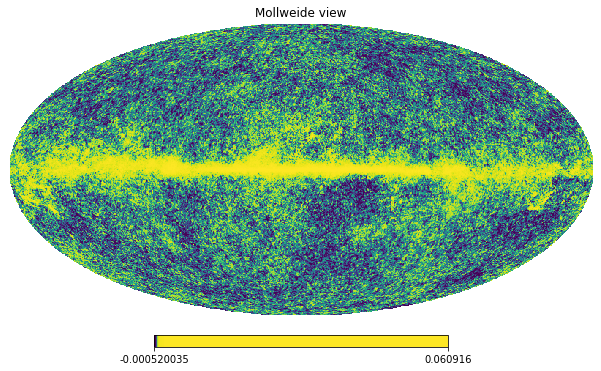

In [25]:
planck = hp.read_map("HFI_SkyMap_100-field-IQU_2048_R3.00_full.fits")
# ros = hp.read_map("rass_healpix_countsec.fits")
# mask = hp.read_map("mask_comprass.fits")

hp.mollview(planck,norm='hist')
# planck_pix = reproject.enmap_from_healpix(ros,shape=shape,wcs=wcs)
# planck_pix = reproject.enmap_from_healpix(planck,shape=shape,wcs=wcs)

In [28]:
np.min(planck)

-0.0005894168862141669

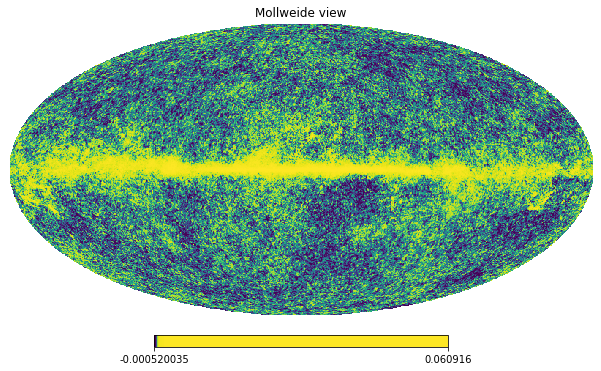

In [27]:
planck[planck<-1e23] = 0
hp.mollview(planck,norm='hist')


---

In [ ]:
NSIDE = 2048
act_w_cmb = hp.ma(actmap_hp)
mask = np.zeros(hp.nside2npix(NSIDE), dtype=np.bool)
mask[(actmap_hp < 5) & (actmap_hp > -5)] = 1
act_w_cmb.mask = mask
hp.mollview(act_w_cmb,norm='hist',title='advACT')

In [ ]:
cmb = hp.read_map("COM_CMB_IQU-nilc_2048_R3.00_full.fits")

In [ ]:
NSIDE = 2048
act_no_cmb = hp.ma(actmap_hp-(cmb*(1000000/3)))
mask = np.zeros(hp.nside2npix(NSIDE), dtype=np.bool)
mask[(actmap_hp < 5) & (actmap_hp > -5)] = 1
act_no_cmb.mask = mask
hp.mollview(act_no_cmb,norm='hist',title='advACT-CMB')

---

In [29]:
stamps90 = []

ras  = ard_not_adv['amf_ra']
decs = ard_not_adv['amf_dec']
# ras  = ard_not_adv[ard_not_adv.amf_rh>50]['amf_ra']
# decs = ard_not_adv[ard_not_adv.amf_rh>50]['amf_dec']
# ras  = amf[amf.amf_rh>50]['amf_ra']
# decs = amf[amf.amf_rh>50]['amf_dec']

N = len(ras)
# N=200
stack_CMB_kSZ           = 0
stack_CMB_kSZ_deproject = 0
c = 0

for i in tqdm(range(N)):
    print(decs[i],ras[i])
    stamp = reproject.thumbnails(actmap,coords = np.deg2rad([decs[i], ras[i]]),r=5*utils.arcmin)
#     stamp_1arc = reproject.thumbnails(actmap,coords = np.deg2rad([decs[i], ras[i]]),r=5*utils.arcmin)
    
    if stamp is None:
        continue
    elif stamp[0][0][0]==0.0:
        continue
        
    stamps90.append(sum(sum(stamp[0])))
    
    stack_CMB_kSZ += stamp 
    c += 1
    plt.imshow(stamp[0])
#     plt.title(amf.iloc[i]['red_id'], fontsize = 16)
#     plt.savefig('ex{}.png'.format(i))
    plt.show()
    
# Normalize the stamps
stack_CMB_kSZ /= c
stack_CMB_kSZ_deproject /= c

  0%|          | 0/21538 [00:00<?, ?it/s]

32.1398 260.6324


NameError: name 'actmap' is not defined

In [30]:
stamps90 = []

ras  = ard_not_adv['amf_ra']
decs = ard_not_adv['amf_dec']
# ras  = ard_not_adv[ard_not_adv.amf_rh>50]['amf_ra']
# decs = ard_not_adv[ard_not_adv.amf_rh>50]['amf_dec']
# ras  = amf[amf.amf_rh>50]['amf_ra']
# decs = amf[amf.amf_rh>50]['amf_dec']

N = len(ras)
# N=200
stack_CMB_kSZ           = 0
stack_CMB_kSZ_deproject = 0
c = 0

for i in tqdm(range(N)):
    print(decs[i],ras[i])
    stamp = reproject.thumbnails(planck_pix,coords = np.deg2rad([decs[i], ras[i]]),r=10*utils.arcmin)
#     stamp_1arc = reproject.thumbnails(planck_pix,coords = np.deg2rad([decs[i], ras[i]]),r=5*utils.arcmin)
    
    if stamp is None:
        continue
    elif stamp[0][0][0]==0.0:
        continue
        
    stamps90.append(sum(sum(stamp[0])))
    
    stack_CMB_kSZ += stamp 
    c += 1
    plt.imshow(stamp[0])
#     plt.title(amf.iloc[i]['red_id'], fontsize = 16)
#     plt.savefig('ex{}.png'.format(i))
    plt.show()
    
# Normalize the stamps
stack_CMB_kSZ /= c
stack_CMB_kSZ_deproject /= c

  0%|          | 0/21538 [00:00<?, ?it/s]

32.1398 260.6324


NameError: name 'planck_pix' is not defined

---

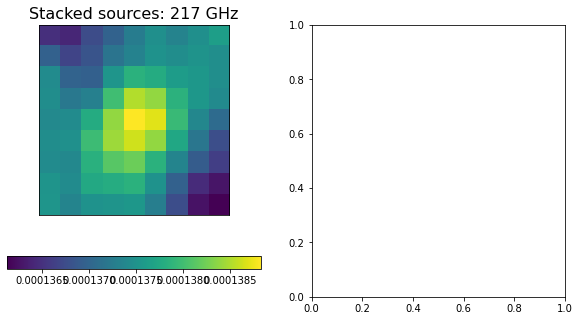

In [24]:
# Now we can plot both of these and compare
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

f, ax = plt.subplots(1,2, figsize=(10, 5))

f1 = ax[0].imshow(stack_CMB_kSZ[0])
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# scalebar = AnchoredSizeBar(ax[0].transData,
#                            19.8, '', 'center left', 
#                            pad=0.1,
#                            color='white',
#                            frameon=False,
#                            size_vertical=0.1)
# ax[0].add_artist(scalebar)
# ax[0].text(1,22,"5 arcmin",color='white')

ax[0].set_title("Stacked sources: ROSITA", fontsize = 16)
plt.colorbar(mappable = f1, ax = ax[0],orientation='horizontal')

plt.show()
# plt.savefig("90.png")

---

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

freq = [90,150,220]
full = [-710,-610,615]
highrh = [-1305,-1760,-595]
plt.scatter(freq,highrh,marker='x',c='r')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Avg. signal")
plt.title("High richness clusters",size=16)
plt.grid()
plt.savefig('highrh.png')

---